In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Mon Feb 21 12:19:27 2022
@author: Evan Vickers
this notebook loads and preprocesses mesoscope data within the uobrainflex environment
"""

python -m ipykernel install --user --name=uobrainflex

In [107]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

#Misc
import time, os, sys, pdb
from glob import glob
from fnmatch import fnmatch

#Base
import numpy as np
import pandas as pd
import scipy.io as sio
import scipy.stats as st
from scipy.ndimage import gaussian_filter1d
from scipy.stats import zscore

#Save
import json
import scipy.io as sio
import h5py

#Plot
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import cv2
from PIL import Image
from matplotlib import cm
from matplotlib.backends.backend_pdf import PdfPages
sns.set_style("ticks")

#Model
import ssm

#CCM
#from DelayEmbedding import DelayEmbedding as DE

#User
#import util
#import plotting as usrplt

import warnings
warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
def calculate_meso_dfof(fluorescence, baseline = 10,window = 320):
    #Get sizes
    nROIs, nBins = fluorescence.shape

    if window == None:
        #Calculate baseline fluorescence 
        if baseline == 'mean':
            F = np.mean(fluorescence,axis=1).reshape(-1,1)
        else:
            F = np.percentile(fluorescence, baseline, axis=1).reshape(-1,1)
        
       #Calculate dfof 
        dfof = np.divide(fluorescence - F, F, out = np.zeros((nROIs, nBins),dtype=np.float32),where = F!=0)
    else:
        dfof = np.zeros((nROIs, nBins),dtype=np.float32)
        for t in range(nBins):
            if t < window:
                if baseline == 'mean':
                    F = np.mean(fluorescence[:,slice(0,t+window)],axis=1)
                else:
                    F = np.percentile(fluorescence[:,slice(0,t+window)],baseline,axis=1)
            else:
                if baseline == 'mean':
                    F = np.mean(fluorescence[:,slice(t-window,t+window)],axis=1)
                else:
                    F = np.percentile(fluorescence[:,slice(t-window,t+window)],baseline,axis=1)
            
#             F = F.reshape(-1,1)
            dfof[:,t] = np.divide(fluorescence[:,t] - F, F, out = np.zeros((nROIs,),dtype=np.float32),where = F!=0)
            
    return dfof

In [109]:
#ProcDataDir = '/mnt/data0/McCormick/proc/3056_200924_E235_1_3_1_strips_json_same_plane_IQ_Oct0120/suite2p_out/suite2p/combined'
#BehaviorDir = '/mnt/data0/McCormick/proc/3056_200924_E235_1_3_1_strips_json_same_plane_IQ_Oct0120/behavior_mat_npy'
#RawDataDir = '/mnt/data0/McCormick/raw/3056_200924_E235_meso_am_1/'

ProcDataDir = input("Enter the path to suite2p outputs:")
BehaviorDir = input("Enter the path for behav npys, all in one folder:")
RawDataDir = input("Enter the path to raw data head folder:")
siDataFile = input("Enter the fil")

#fsuffix = '3056_200924_E235_1_3_1'
fsuffix = input("Enter 2P files name ID_date_cage_session_attempt_sub:")

PlotDir = os.path.join('./plots',fsuffix)
if not os.path.isdir(PlotDir):
    os.makedirs(PlotDir)
    
##===== Read in neural data =====##
F = np.load(os.path.join(ProcDataDir,'F.npy'), allow_pickle=True)
Fneu = np.load(os.path.join(ProcDataDir,'Fneu.npy'), allow_pickle=True)
spks = np.load(os.path.join(ProcDataDir,'spks.npy'), allow_pickle=True)
stat = np.load(os.path.join(ProcDataDir,'stat.npy'), allow_pickle=True)
ops =  np.load(os.path.join(ProcDataDir,'ops.npy'), allow_pickle=True)
ops = ops.item()
iscell = np.load(os.path.join(ProcDataDir,'iscell.npy'), allow_pickle=True)
nROIs = len(F)
fs = ops['fs'] #frame rate
framerate = fs

spks_z = zscore(spks,axis=1)

## ===== Read in behavioral data =====##
# behavior = sio.loadmat('/mnt/data0/McCormick/proc/2367_200605_E210_1_perTrim_HAL_Oct1320/facemap/tri_cam_1_concat_30min_proc.mat')
behav_dict = {}
behav_dict['fr_cl_2p'] = np.load(os.path.join(BehaviorDir,'fr_cl_2p.npy'))
behav_dict['lft_ex'] = np.load(os.path.join(BehaviorDir,'lft_ex.npy'))
behav_dict['lft_ppl'] = np.load(os.path.join(BehaviorDir,'lft_ppl.npy'))
behav_dict['lft_whisk'] = np.load(os.path.join(BehaviorDir,'lft_whisk.npy'))
#behav_dict['lick'] = np.load(os.path.join(BehaviorDir,'lick.npy'))
behav_dict['lpup_fc'] = np.load(os.path.join(BehaviorDir,'lpup_fc.npy'))
behav_dict['ni_pzo'] = np.load(os.path.join(BehaviorDir,'ni_pzo.npy'))
behav_dict['p_diode'] = np.load(os.path.join(BehaviorDir,'p_diode.npy'))
#behav_dict['piezo_co'] = np.load(os.path.join(BehaviorDir,'piezo_co.npy'))
behav_dict['rpup_fc'] = np.load(os.path.join(BehaviorDir,'rpup_fc.npy')) 
behav_dict['rt_ex'] = np.load(os.path.join(BehaviorDir,'rt_ex.npy'))
behav_dict['rt_ppl'] = np.load(os.path.join(BehaviorDir,'rt_ppl.npy'))
behav_dict['rt_whisk'] = np.load(os.path.join(BehaviorDir,'rt_whisk.npy'))
behav_dict['sound'] = np.load(os.path.join(BehaviorDir,'sound.npy'))
behav_dict['walk'] = np.load(os.path.join(BehaviorDir,'walk.npy'))
SI_path=RawDataDir+'\\'+fsuffix+'_header.csv'
behav_dict['SI_tstamp_2p']=np.loadtxt(SI_path, delimiter=",", skiprows=0)

Enter the path to suite2p outputs: D:\Mesoscope_Analysis_IV_May27_2021-\E267_A1V1M2\4022_210922_E267_0_1_1_2D_IQ\suite2p_out\suite2p\plane0
Enter the path for behav npys, all in one folder: D:\Mesoscope_Analysis_IV_May27_2021-\E267_A1V1M2\4022_210922_E267_0_1_1_2D_IQ\behavior_mat_npy
Enter the path to raw data head folder: D:\McCormick_Data_May27_2021-\2021\Sept\4022_210922_E267_BW039_meso_am\2P
Enter 2P files name ID_date_cage_session_attempt_sub: 4022_210922_E267_BW039_0_1_1


What is the resolution, in micrometers per pixel: 5


(924, 900)


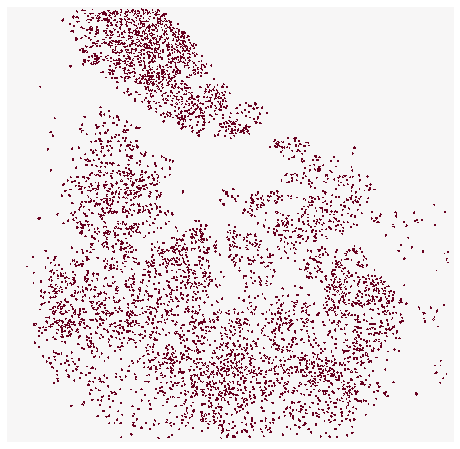

In [166]:
res_int = int(input("What is the resolution, in micrometers per pixel:"))
#res_int = 5 #Resolution, in micrometers per pixel
im = np.zeros((ops['Lx'], ops['Ly']))

for n in range(0,nROIs):
    if iscell[n,0]==1:
        ypix = stat[n]['ypix'][~stat[n]['overlap']]#*res_int
        xpix = stat[n]['xpix'][~stat[n]['overlap']]#*res_int
        if (iscell[n,0] == 1) & (iscell[n,1] > 0.50):
            im[xpix,ypix] = 1
        else:
            im[xpix,ypix] = -1

fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(im,ax=ax,cmap='RdBu_r',center=0,cbar=False)#,color_continuous_scale='RdBu_r')
print(im.shape)

plt.imsave(os.path.join(PlotDir,'neural-location_real_{}_MMM.png'.format(fsuffix)),im)

ax.axis('off')
plt.savefig(os.path.join(PlotDir,'neural-location_{}.png'.format(fsuffix)))

In [167]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 16 17:09:27 2021
@author: Daniel Hulsey
this script is used to align a CCF to a multimodalmapping session. Points selected to align the ccf will be saved for future use.
"""

import os
from skimage import io
import uobrainflex.utils.image_utilities as im_util
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from tkinter import filedialog

root = tk.Tk()
root.withdraw()

mmm_title = 'Select multi modal map image'
mmm_dir = 'C:\\Users\\admin\\Desktop\\figure dump\\CCF'
mmm_image_path = filedialog.askopenfilename(title = mmm_title, initialdir = mmm_dir)

##hardcode this? or put it in conf file?
ccf_title = 'Select CCF image'
ccf_dir = 'C:\\Users\\admin\\Desktop\\figure dump\\CCF'
ccf_file_path = filedialog.askopenfilename(title = ccf_title, initialdir = ccf_dir)


save_folder = os.path.dirname(mmm_image_path)
subject = os.path.basename(mmm_image_path)
subject = subject[:subject.find("_")]


mmm_image = io.imread(mmm_image_path)
ccf_image = io.imread(ccf_file_path)
mmm_points, ccf_points, figure = im_util.set_transform_anchors(mmm_image, ccf_image)

plt.savefig(save_folder + '/' + subject +'_mmm_ccf_fit.png')
np.save(save_folder + '/' + subject + '_mmm_points',mmm_points)
np.save(save_folder + '/' + subject + '_ccf_points',ccf_points)


ModuleNotFoundError: No module named 'uobrainflex'

In [1]:
import uobrainflex.utils.image_utilities as im_util

ModuleNotFoundError: No module named 'uobrainflex'

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Thu Dec 16 17:09:27 2021
@author: Daniel Hulsey
this script aligns a ccf to an individual session, and extracts dff data for each indicated region. 
Running it fully requires:
    1. saved dff trace for the session being analyzed
    2. saved points to align CCF to multimodalmap session
    3. blood vessel images from the CCF and session for analysis for alignment
Save location for the region dff traces needs to be better defined    
"""

from skimage import io
import uobrainflex.utils.image_utilities as im_util
import matplotlib.pyplot as plt
import numpy as np
import tkinter as tk
from tkinter import filedialog
import glob 
from PIL import Image

def area_mean_dff(dff,pixel_list):
    xs = pixel_list[0,:]
    ys = pixel_list[1,:]
    return np.mean(dff[:,xs,ys],axis=1)

def area_max_dff(dff,pixel_list):
    xs = pixel_list[0,:]
    ys = pixel_list[1,:]
    return np.max(dff[:,xs,ys],axis=1)

# select folders and align session and mmm vessel images
newfolders=''
while newfolders != 'n': # repeat until user indicates that new folders should not be selected
    
    subject_title = 'select subject mmm folder'
    session_title = 'select session folder'
    root = tk.Tk()
    root.withdraw()
    subject_folder = filedialog.askdirectory(title = subject_title)
    session_folder = filedialog.askdirectory(title = session_title)
    save_folder = session_folder
    

    mmm_image_path = glob.glob(subject_folder + '/*MMM.png')[0]
    
    # session_vessels_path = glob.glob(subject_folder + '/*vessel*')[0] ## this is the future one. below for testing
    session_vessels_path = glob.glob(session_folder + '/*MMM.png')[0]
        
    mmm_image = io.imread(mmm_image_path)
    vessel_image = io.imread(session_vessels_path)
    
    repeat_align=''
    while repeat_align != 'n': # repeat until user replys to not
        session_vessel_points, session_mmm_points, figure = im_util.set_transform_anchors(vessel_image, mmm_image)
        plt.savefig(save_folder +'\mmm_to_session_align.png')
        repeat_align = input("repeat alignment with these images? Y/n\n")
    newfolders = input("repeat alignment with different folder selections? Y/n\n")
    

plt.savefig(save_folder +'\mmm_to_session_align.png')
np.save(save_folder + '\session_mmm_points',session_mmm_points)
np.save(save_folder + '\session_vessel_points',session_vessel_points)

# # Now grab MMM & CCF alignments & DFF, create session masks, and grab mean region dffs
# print('loading dff data')
# # dff_filepath =  glob.glob(session_folder + '/*dff.npy')[0] # this is real one to use. hardcoded to demo with no real data
# dff_filepath =  'T:/BW048_211013_115911/WF_raw/WF_raw_dff.npy'
# dff = np.load(dff_filepath)

mmm_points_filepath = glob.glob(subject_folder + '/*mmm_points.npy')[0]
ccf_points_filepath = glob.glob(subject_folder + '/*ccf_points.npy')[0]
masks_filepath = 'C:\\Users\\McCormick Lab\\Documents\\Python\\Hulsey_A1V1M2_CCF_affine_Jan1122\\22deg\\masks.npy'
areas_filepath = 'C:\\Users\\McCormick Lab\\Documents\\Python\\Hulsey_A1V1M2_CCF_affine_Jan1122\\22deg\\areas.npy'

mmm_points = np.load(mmm_points_filepath)
ccf_points = np.load(ccf_points_filepath)
masks = np.load(masks_filepath)
areas = np.load(areas_filepath)


# st2, wp2 = im_util.set_transform_anchors(session_vessels, mmm_vessels)

print('aligning ccf regions')
session_masks=[]
mmm_masks=[]
for i, mask in enumerate(masks):
    mmm_mask = im_util.transform_image(mmm_image, mask, mmm_points, ccf_points)
    mmm_mask[mmm_mask<.001]=0
    mmm_mask[mmm_mask>0]=1
    mmm_masks.append(mmm_mask)
    
    session_mask = im_util.transform_image(vessel_image, mmm_mask, session_vessel_points, session_mmm_points)
    session_mask[session_mask<.01]=0
    session_mask[session_mask>0]=1
    
    session_masks.append(session_mask)
session_masks = np.array(session_masks)

mmm_masks = np.array(mmm_masks)

plt.figure()
plt.imshow(np.sum(session_masks,axis=0))

plt.imshow(mmm_mask)
plt.imshow(mask)

session_masks = im_util.reduce_mask_overlap(session_masks)

plt.figure()
plt.imshow(np.sum(session_masks,axis=0))

outlines=im_util.masks_to_outlines(session_masks)
plt.figure()
plt.imshow(np.sum(outlines,axis=0))

outlines_pil=Image.fromarray(np.sum(outlines,axis=0)*255)
plt.figure()
outlines_pil.show()

plt.figure()
plt.imshow(vessel_image)
plt.imshow(np.sum(outlines,axis=0),cmap="gray")

vessel_outlines=vessel_image
outlines_flat=np.sum(outlines,axis=0)*255

for i in range(len(vessel_image[:,0,0])):
    for j in range(len(vessel_image[0,:,0])):
        if outlines_flat[i,j]>0:
            vessel_outlines[i,j,:]=255

plt.figure()
plt.imshow(vessel_outlines)
plt.savefig(save_folder +'\ccf_to_session_align_meso.png')

vessel_outlines_swap = vessel_outlines.transpose(1, 0, 2)
plt.figure()
plt.imshow(vessel_outlines_swap)
plt.savefig(save_folder +'\ccf_to_session_align_rotated.png')

# print('extracting are dff values')
# area_list = ['r_VISp','r_AUDp','r_MOs']
# for area in area_list:
#     # plt.figure()
#     mask_ind = np.where(areas==area)[0]
#     this_mask = session_masks[mask_ind,:,:][0].T
#     this_dff = area_mean_dff(dff,np.array(np.where(this_mask)))
#     np.save(save_folder + '/' + area + '_dff',this_dff)
    

In [6]:
#Get fluorescence for ROIs we strongly believe to be cells
iscell_bool = (iscell[:,0] == 1) & (iscell[:,1] > 0.50)
fluorescence = F[iscell_bool]
neuropil = Fneu[iscell_bool]
events = spks[iscell_bool]
events_binary = events > 0
stat_sub = [stat[i] for i in range(nROIs) if iscell_bool[i]]
spks_z = spks_z[iscell_bool]

#Neuropil subtraction
F_sub = fluorescence - 0.7*neuropil

#Calclate dfof based on a mean baseline fluorescence
dfof = calculate_meso_dfof(F_sub,10,window=100)
nNeurons, T = dfof.shape

#Z-score dfof
dfof_z = zscore(dfof,axis=1)
N, T = dfof_z.shape

In [5]:
#Perform PCA on z-scored dfof
from sklearn.decomposition import PCA
pca = PCA(n_components=N)

dfof_transform = pca.fit_transform(dfof_z.T)

0.99999994


Text(0, 0.5, 'Var Expl')

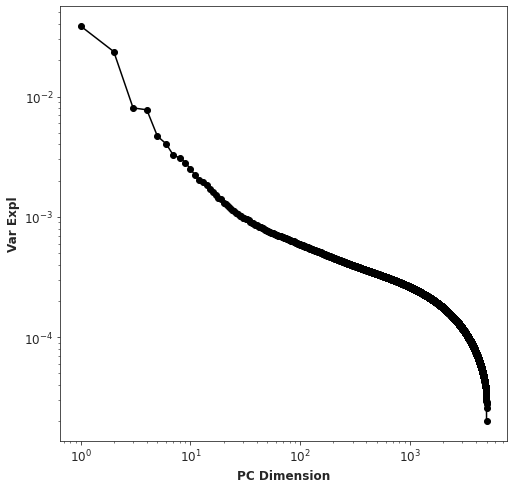

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
print(np.sum(pca.explained_variance_ratio_))
plt.plot(x,y,'-ok')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel('PC Dimension')
ax.set_ylabel('Var Expl')

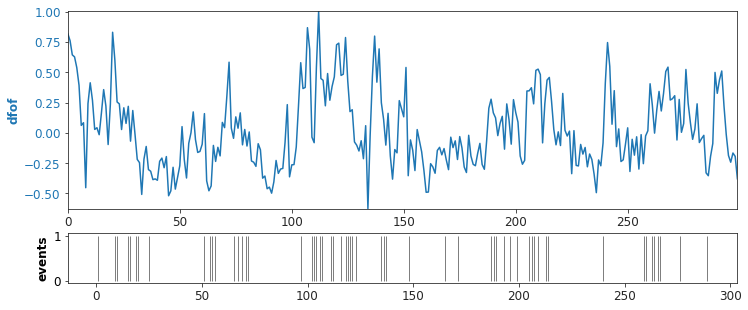

In [22]:
iCell = 2
nT_plot = 300; tStart = 0
plotslice = slice(tStart,tStart+nT_plot)

fig, axes = plt.subplots(2,1,figsize=(12,5),gridspec_kw={'height_ratios':[4,1]})
# axes[0].plot(dfof[iCell,plotslice])
# axes[0].plot(events[iCell,plotslice])

ax = axes[0]
color = 'tab:blue'
ax.set_xlabel('time (frames)')
ax.set_ylabel('dfof', color=color)
ax.plot(dfof[iCell,plotslice], color=color)
# ax.plot(dfof_z[iCell,plotslice], color='k')
# ax.plot(dfof_norm[iCell,plotslice], color='r')
ax.tick_params(axis='y', labelcolor=color)
ax.autoscale(tight=True)

ax2 = axes[1]# ax.twinx()  # instantiate a second axes that shares the same x-axis

color = 'black'
ax2.set_ylabel('events', color=color)  # we already handled the x-label with ax1
ax2.vlines(np.where(events_binary[iCell,plotslice] == 1)[0],0,1, color=color,lw=0.5)
ax2.tick_params(axis='y', labelcolor=color)

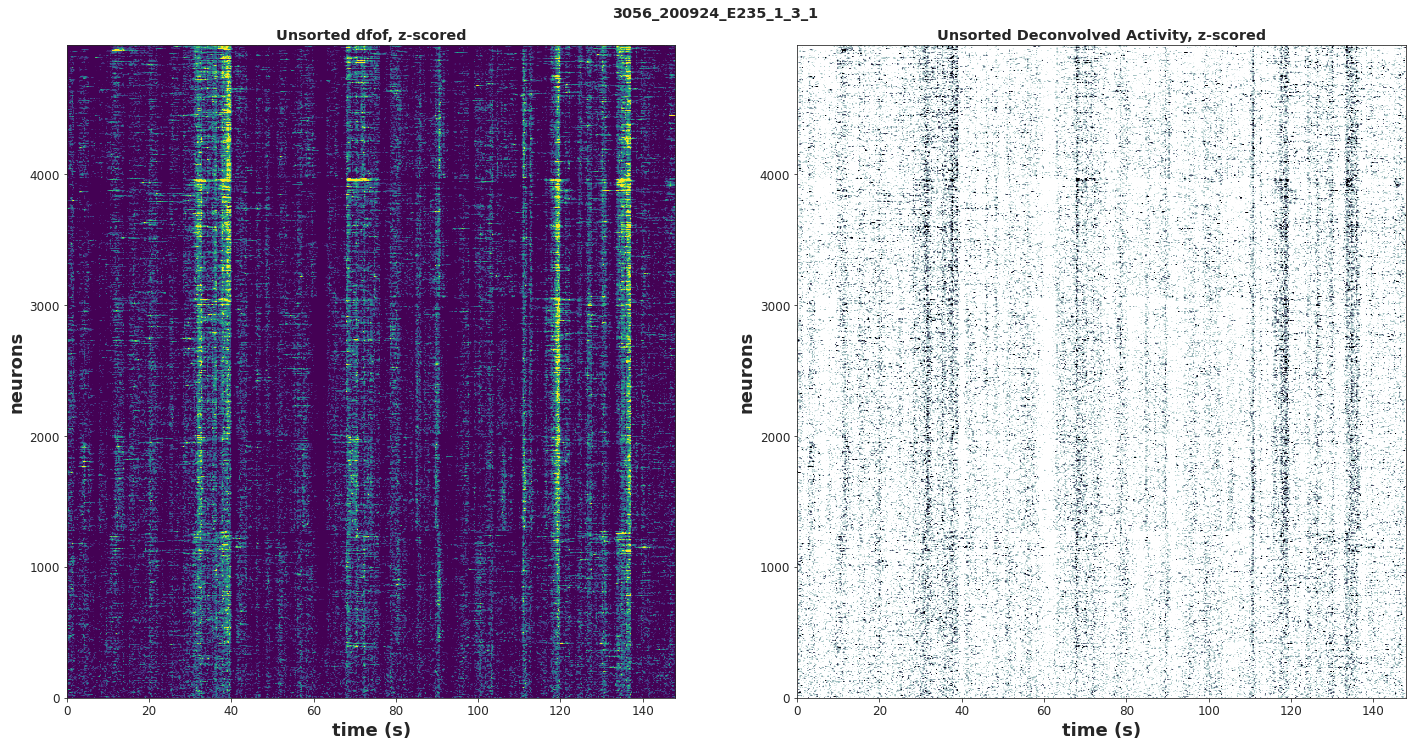

In [23]:
### view neuron sorting (suite2p sorting)
# iStart = 1500; nPts = 500
# plotslice = slice(iStart,iStart+nPts)
# fs = 3.5 # sampling rate of data in Hz
# splot = spks_z[::-1,plotslice]
# plt.figure(figsize=(16,10))
# ax=plt.imshow(splot, vmin=0,vmax=1.5,cmap='viridis',aspect='auto',extent=[0,splot.shape[1]/fs, 0,splot.shape[0]])
# plt.xlabel('time (s)', fontsize=18)
# plt.ylabel('neurons', fontsize=18)
# plt.title('Unsorted Deconvolved Activity, z-scored')
# plt.colorbar()
# plt.show()

#add usr defined length = fs*min*60 (s)

nT_plot = 18252; tStart = 0
plotslice = slice(tStart,tStart+nT_plot)

fig, axes = plt.subplots(1,2,figsize=(24,12))
plt.suptitle(fsuffix,y=0.925)

ax = axes[0]
ax.set_title('Unsorted dfof, z-scored')
splot = dfof_z[::-1,plotslice]
cm = ax.imshow(splot[::-1], vmin=0,vmax=1.5,cmap='viridis',aspect='auto',extent=[0,splot.shape[1]/fs, 0,splot.shape[0]]) #vmin=-1.5,vmax=1.5,cmap='RdBu_r'
# plt.colorbar(cm,ax=ax)

ax = axes[1]
ax.set_title('Unsorted Deconvolved Activity, z-scored')
splot = spks_z[::-1,plotslice]
ax.imshow(splot[::-1], vmin=0,vmax=1.5,cmap='bone_r',aspect='auto',extent=[0,splot.shape[1]/fs, 0,splot.shape[0]])


for ax in axes:
    ax.set_xlabel('time (s)', fontsize=18)
    ax.set_ylabel('neurons', fontsize=18)

plt.savefig(os.path.join(PlotDir,'unsorted_neuralactivity_{}.png'.format(fsuffix)))

In [24]:
# >> from github <<
import sys
sys.path.append('/home/dwyrick/Git/rastermap/rastermap/')
from mapping import Rastermap

model = Rastermap(n_components=1, n_X=100, nPC=500, init='pca').fit(spks_z)

### sort neurons and smooth across neurons and zscore in time
isort = np.argsort(model.embedding[:,0])
# isort1 = np.argsort(model.embedding[:,1])

# Sm = gaussian_filter1d(spks_z[isort,:].T, np.minimum(3,int(spks_z.shape[0]*0.005)), axis=1)
# Sm = Sm.T

nmin 500
0.23859763145446777
6.403954029083252
6.677863597869873
6.710449457168579
(98, 100)
(130,)
1.0
time; iteration;  explained PC variance
0.41s     0        0.0125      2
0.67s    10        0.0602      4
0.92s    20        0.0754      8
1.17s    30        0.0915      18
1.42s    40        0.1038      28
1.68s    50        0.1120      38
1.94s    60        0.1182      48
2.19s    70        0.1238      58
2.45s    80        0.1286      68
2.70s    90        0.1328      78
2.96s    100        0.1365      88
3.22s    110        0.1403      98
3.48s    120        0.1406      98
3.72s   final      0.1406
3.72s upsampled    0.1406


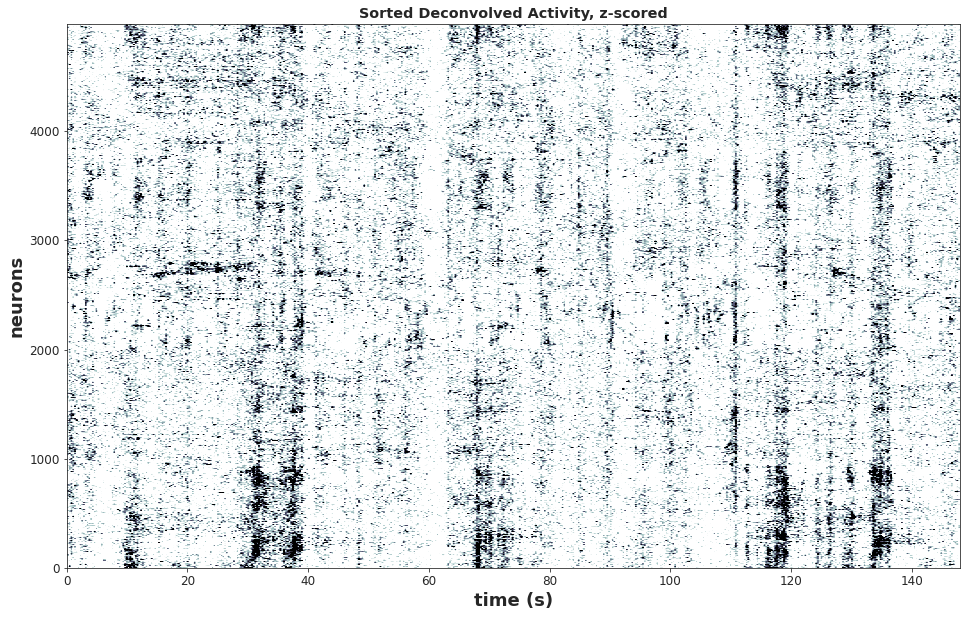

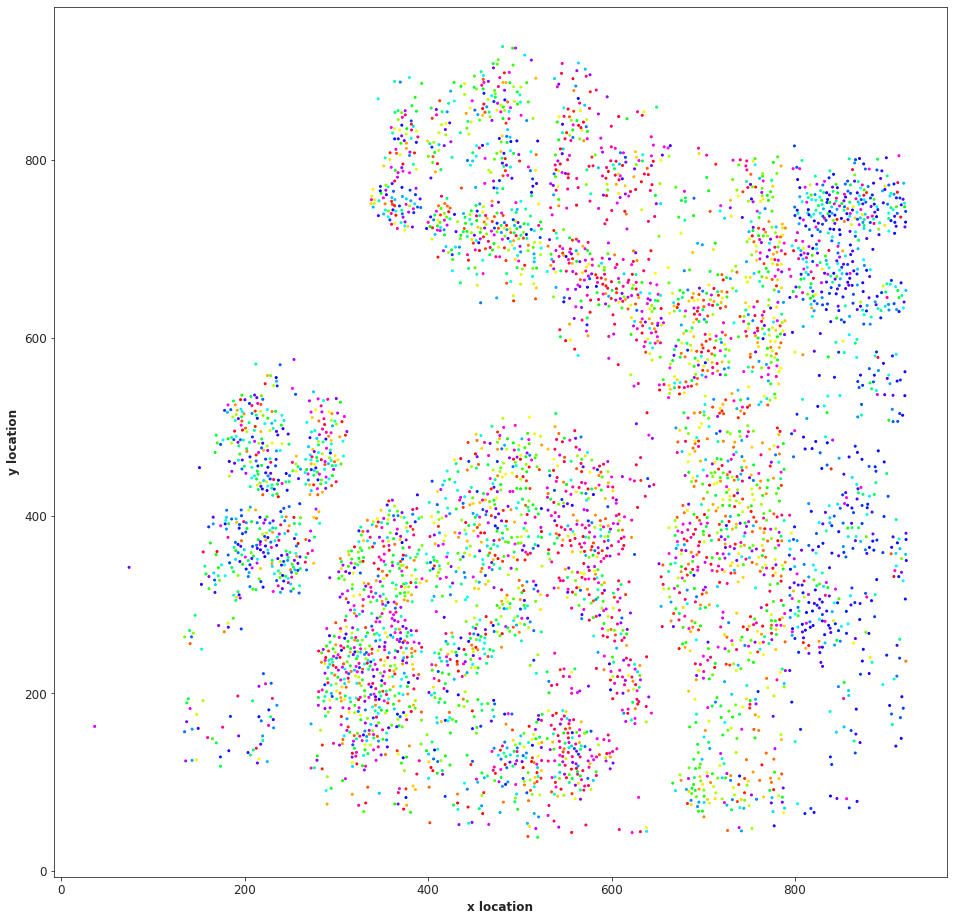

In [27]:
### view neuron sorting

splot = spks_z[isort,plotslice]
plt.figure(figsize=(16,10))
ax=plt.imshow(splot[::-1], vmin=0,vmax=1,cmap='bone_r',aspect='auto',extent=[0,splot.shape[1]/fs, 0,splot.shape[0]])
plt.xlabel('time (s)', fontsize=18)
plt.ylabel('neurons', fontsize=18)
# plt.colorbar()
plt.title('Sorted Deconvolved Activity, z-scored')
plt.savefig(os.path.join(PlotDir,'sorted_deconvolved-events_{}.png'.format(fsuffix)))

### view positions of cells colored by rastermap
# colormap
cmap = cm.get_cmap(name='hsv')
cmap = cmap(np.linspace(0.,1,nNeurons))

xyloc = np.zeros((nNeurons,2))
for n in range(0,nNeurons):
    ypix = np.mean(stat_sub[n]['ypix'][~stat_sub[n]['overlap']])#*res_int
    xpix = np.mean(stat_sub[n]['xpix'][~stat_sub[n]['overlap']])#*res_int

    xyloc[n,0] = xpix; xyloc[n,1] = ypix;

fig, ax = plt.subplots(figsize=(16,16))
# assign color based on embedding
plt.scatter(xyloc[:,0], xyloc[:,1], s=4, color=cmap[isort,:])
plt.xlabel('x location')
plt.ylabel('y location');



In [ ]:
# >> from github <<
import sys
sys.path.append('/home/dwyrick/Git/rastermap/rastermap/')
from mapping import Rastermap

model_dfof = Rastermap(n_components=1, n_X=100, nPC=400, init='pca').fit(dfof_z)

### sort neurons and smooth across neurons and zscore in time
isort_dfof = np.argsort(model_dfof.embedding[:,0])
# isort1 = np.argsort(model.embedding[:,1])

# Sm = gaussian_filter1d(spks_z[isort,:].T, np.minimum(3,int(spks_z.shape[0]*0.005)), axis=1)
# Sm = Sm.T



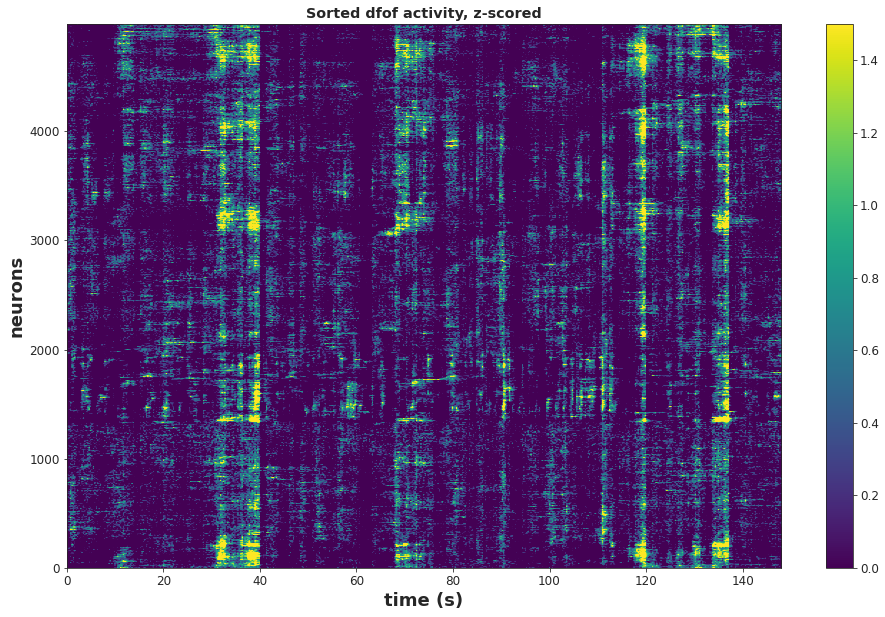

In [13]:
### view neuron sorting
splot = dfof_z[isort_dfof,plotslice]
plt.figure(figsize=(16,10))

ax=plt.imshow(splot[::-1], vmin=0,vmax=1.5,cmap='viridis',aspect='auto',extent=[0,splot.shape[1]/fs, 0,splot.shape[0]])
plt.xlabel('time (s)', fontsize=18)
plt.ylabel('neurons', fontsize=18)
plt.colorbar()
plt.title('Sorted dfof activity, z-scored')
plt.savefig(os.path.join(PlotDir,'sorted_dfof_{}.png'.format(fsuffix)))

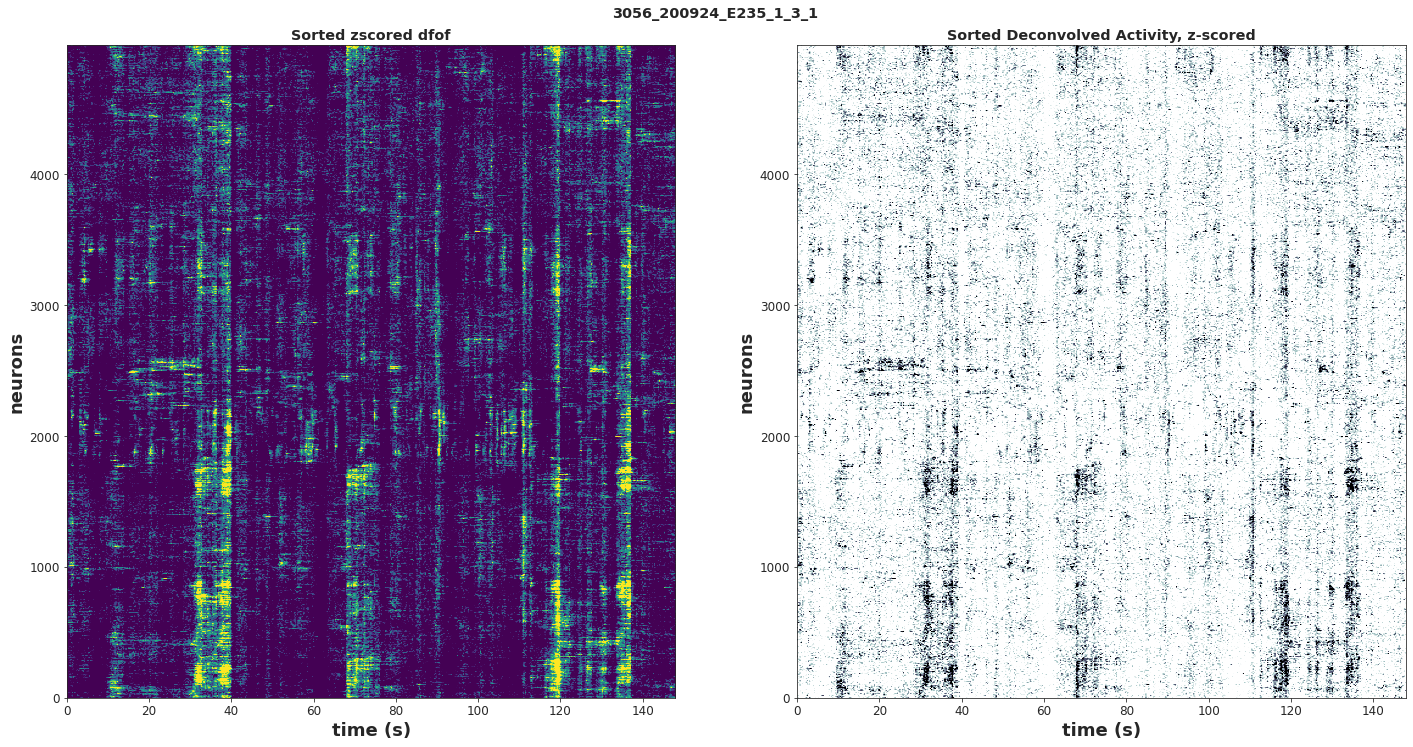

In [8]:
nT_plot = 500; tStart = 1500
plotslice = slice(tStart,tStart+nT_plot)

fig, axes = plt.subplots(1,2,figsize=(24,12))
plt.suptitle(fsuffix,y=0.925)

ax = axes[0]
ax.set_title('Sorted zscored dfof')
splot = dfof_z[isort,plotslice]
ax.imshow(splot[::-1], vmin=0,vmax=1.5,cmap='viridis',aspect='auto',extent=[0,splot.shape[1]/fs, 0,splot.shape[0]])


ax = axes[1]
ax.set_title('Sorted Deconvolved Activity, z-scored')
splot = spks_z[isort,plotslice]
ax.imshow(splot[::-1], vmin=0,vmax=1.5,cmap='bone_r',aspect='auto',extent=[0,splot.shape[1]/fs, 0,splot.shape[0]])


for ax in axes:
    ax.set_xlabel('time (s)', fontsize=18)
    ax.set_ylabel('neurons', fontsize=18)

plt.savefig(os.path.join(PlotDir,'sorted_neuralactivity_{}.png'.format(fsuffix)))

In [22]:
masks_filepath = 'C:\\Users\\McCormick Lab\\Documents\\Python\\Hulsey_A1V1M2_CCF_affine_Jan1122\\22deg\\masks.npy'
areas_filepath = 'C:\\Users\\McCormick Lab\\Documents\\Python\\Hulsey_A1V1M2_CCF_affine_Jan1122\\22deg\\areas.npy'

In [21]:
masks = np.load(masks_filepath)
areas = np.load(areas_filepath)

In [99]:
plt.figure(figsize = (10,10))
for i in range(masks.shape[0]):
    plt.imshow(masks[i,:,:])
areas[56]

NameError: name 'session_masks' is not defined

<Figure size 720x720 with 0 Axes>

In [24]:
areas

array(['l_VISp', 'l_VISpl', 'l_VISpor', 'l_VISl', 'l_VISli', 'l_VISal',
       'l_VISrl', 'l_VISa', 'l_VISam', 'l_VISpm', 'l_FRP', 'l_PL',
       'l_ACAd', 'l_MOs', 'l_MOp', 'l_RSPv', 'l_RSPd', 'l_RSPagl',
       'l_SSp-tr', 'l_SSp-ll', 'l_SSp-ul', 'l_SSp-m', 'l_SSp-n',
       'l_SSp-un', 'l_SSp-bfd', 'l_SSs', 'l_AUDp', 'l_AUDv', 'l_AUDd',
       'l_AUDpo', 'l_TEa', 'r_VISp', 'r_VISpl', 'r_VISpor', 'r_VISl',
       'r_VISli', 'r_VISal', 'r_VISrl', 'r_VISa', 'r_VISam', 'r_VISpm',
       'r_FRP', 'r_PL', 'r_ACAd', 'r_MOs', 'r_MOp', 'r_RSPv', 'r_RSPd',
       'r_RSPagl', 'r_SSp-tr', 'r_SSp-ll', 'r_SSp-ul', 'r_SSp-m',
       'r_SSp-n', 'r_SSp-un', 'r_SSp-bfd', 'r_SSs', 'r_AUDp', 'r_AUDv',
       'r_AUDd', 'r_AUDpo', 'r_TEa'], dtype='<U9')

In [106]:
np.where(masks[1,:,:]==0)

(array([   0,    0,    0, ..., 1319, 1319, 1319], dtype=int64),
 array([   0,    1,    2, ..., 1356, 1357, 1358], dtype=int64))

In [42]:
ops['Lx']

924

In [43]:
ops['Ly']

900

In [44]:
ops['nframes']

8899

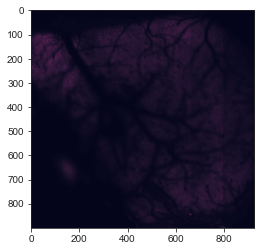

In [45]:
plt.imshow(ops['refImg'])

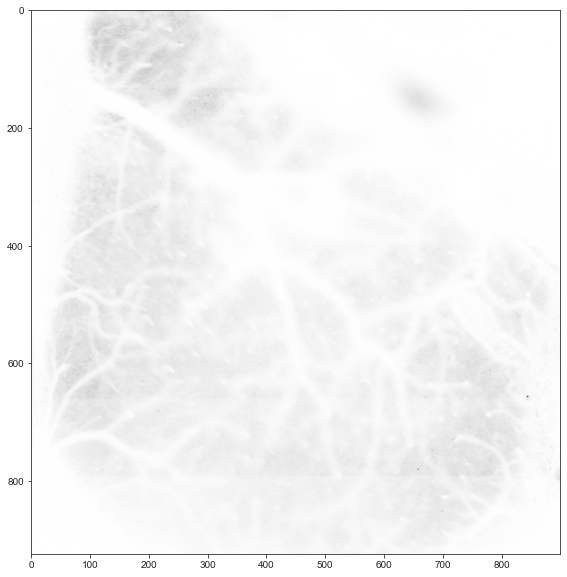

In [69]:
plt.figure(figsize = (10,10))
plt.imshow(np.transpose(ops['meanImg']),cmap='binary',alpha=1)

In [74]:
ops['meanImg'].shape

(900, 924)

In [75]:
meanImg_rect=np.where(ops['meanImg']=0,0,ops['meanImg']=1)

SyntaxError: keyword can't be an expression (<ipython-input-75-d465a2285507>, line 1)

In [157]:
behav_dict['fr_cl_2p'].shape[0]

21044564

In [153]:
dur=int(behav_dict['SI_tstamp_2p'].shape[0])/ops['fs']

In [154]:
dur

4237.797619047619

In [152]:
dur*5000

21188988.095238097

In [148]:
behav_dict['rpup_fc'].shape[0]/30

4207.4

In [149]:
ops['fs']

3.36

In [165]:
behav_dict['SI_tstamp_2p'].shape[0]/3.36

4237.797619047619

In [162]:
behav_dict['rpup_fc'].shape[0]

126222

In [164]:
126222/30

4207.4